# Time Series Prediction with Hénon–Heiles Eqaution Inspired Deep Learning ($HPINN$)

AUTHOR: Anurag Dutta (anuragdutta.research@gmail.com)

SUPERVISOR: Tanujit Chakraborty (tanujit.chakraborty@sorbonne.ae)

CREATED: 2023-03-11 21:53:12

## Gathering Dependencies

_Importing Required Libraries_

In [1]:
pip install hampel

You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

## Loading Datasets

_KYOTO DST_

In [3]:
data = pd.read_csv("datasets/dst.csv")
training_set = data.iloc[:, 1]
print(training_set)

0         -7
1        -10
2        -10
3         -6
4         -2
          ..
139867   -16
139868   -14
139869   -14
139870   -15
139871   -14
Name: dst, Length: 139872, dtype: int64


## Computing the Gradients

_Calculating the value of_ $\frac{dx}{dt}$, _and_ $\frac{d^2x}{dt^2}$

In [4]:
t_diff = 0.0416 # Hourly Data (1/24)
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:]
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:]
print(gradient_tt)

67
1         -72.115385
2           0.000000
3          96.153846
4          96.153846
5         120.192308
             ...    
139867     96.153846
139868     48.076923
139869      0.000000
139870    -24.038462
139871     24.038462
Name: dst, Length: 139871, dtype: float64
2         1733.542899
3         2311.390533
4            0.000000
5          577.847633
6        -1733.542899
             ...     
139867       0.000000
139868   -1155.695266
139869   -1155.695266
139870    -577.847633
139871    1155.695266
Name: dst, Length: 139870, dtype: float64


In [5]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
gradient_tt = gradient_tt.reset_index(drop=True)
print(gradient_t)
print(gradient_tt)

0         -72.115385
1           0.000000
2          96.153846
3          96.153846
4         120.192308
             ...    
139866     96.153846
139867     48.076923
139868      0.000000
139869    -24.038462
139870     24.038462
Name: dst, Length: 139871, dtype: float64
0         1733.542899
1         2311.390533
2            0.000000
3          577.847633
4        -1733.542899
             ...     
139865       0.000000
139866   -1155.695266
139867   -1155.695266
139868    -577.847633
139869    1155.695266
Name: dst, Length: 139870, dtype: float64


In [6]:
print(gradient_t.shape)
print(training_set.shape[:-1])
df = pd.concat((training_set[:-1], gradient_t), axis=1)
gradient_tt.columns = ["grad_tt"]
df = pd.concat((df[:-1], gradient_tt), axis=1)
df.columns = ['y_t', 'grad_t', 'grad_tt']

(139871,)
()


## Plot of the External Forcing from Chaotic Differential Equation (_Henon Heiles Equation_)

_Parameters_: $\lambda=1\\$

<AxesSubplot:>

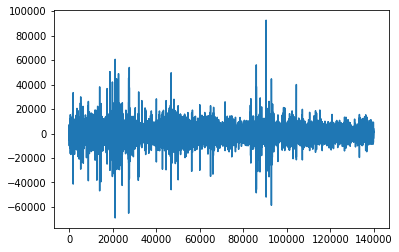

In [7]:
L = df.iloc[:, 2] - df.iloc[:, 1]
L.plot()

## Preprocessing the Data into Supervised Learning

In [8]:
def Supervised(data, n_in=1):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    cols.append(df)
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    sup = pd.concat(cols, axis=1)
    sup.columns = names
    sup.dropna(inplace=True)
    return sup


data = Supervised(df.values, n_in=10)
data.drop(['var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
           'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
           'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
           'var3(t-2)', 'var2(t-1)', 'var3(t-1)', 'var2(t-3)', 'var3(t-3)'], axis=1, inplace=True)
print(data.head())
print(data.columns)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data.shape)
y = data[:, -3:]
x = data[:, :-3]
print(x.shape)


    var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
10        -7.0      -10.0      -10.0       -6.0       -2.0        3.0   
11       -10.0      -10.0       -6.0       -2.0        3.0        5.0   
12       -10.0       -6.0       -2.0        3.0        5.0        5.0   
13        -6.0       -2.0        3.0        5.0        5.0        3.0   
14        -2.0        3.0        5.0        5.0        3.0        1.0   

    var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)    var2(t)     var3(t)  
10        5.0        5.0        3.0        1.0      1.0  24.038462 -577.847633  
11        5.0        3.0        1.0        1.0      2.0   0.000000  577.847633  
12        3.0        1.0        1.0        2.0      2.0  24.038462 -577.847633  
13        1.0        1.0        2.0        2.0      3.0   0.000000  577.847633  
14        1.0        2.0        2.0        3.0      3.0  24.038462  577.847633  
Index(['var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)',
  

## Train and Test Split

In [9]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
dataX = np.array(x)
dataY = np.array(y)
trainX = np.array(x[0:train_size])
trainY = np.array(y[0:train_size])
testX = np.array(x[train_size:len(x)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(111888, 1, 10) (111888, 3) (27972, 1, 10) (27972, 3)


## Defining the Physical Loss

In [10]:
a = tf.Variable(0.1, name="alpha", trainable=True, dtype=tf.float32)
b = tf.Variable(0.05, name="beta", trainable=True, dtype=tf.float32)
c = tf.Variable(1.1, name="gamma", trainable=True, dtype=tf.float32)
d = tf.Variable(0.1, name="delta", trainable=True, dtype=tf.float32)


def phys(y_pred, y_true):
    return mean_absolute_error((y_true[:, 2] - y_true[:, 1]), (y_pred[:, 2] - y_pred[:, 1]))

def phys2(y_pred, y_real):
    pred = y_pred[2:]-2*y_pred[1:-1]-y_pred[:-2] - (y_pred[1:-1]-y_pred[:-2])
    real = y_real[2:]-2*y_real[1:-1]-y_real[:-2] - (y_real[1:-1]-y_pred[:-2])
    return(mean_absolute_error(pred, real))

## Model ($HPINN$)

In [11]:
a = tf.Variable(0.1, name="alpha", trainable=True, dtype=tf.float32)
b = tf.Variable(0.05, name="beta", trainable=True, dtype=tf.float32)
c = tf.Variable(1.1, name="gamma", trainable=True, dtype=tf.float32)
d = tf.Variable(0.1, name="delta", trainable=True, dtype=tf.float32)

def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    squared_difference3 = tf.square((y_pred[:, 2] - y_pred[:, 1]))
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)

model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(3))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX, trainY, epochs=500, batch_size=64,
                    validation_data=(testX, testY), verbose=2, shuffle=False)

Epoch 1/500
1749/1749 - 22s - loss: 0.0046 - val_loss: 1.5685e-04 - 22s/epoch - 13ms/step
Epoch 2/500
1749/1749 - 10s - loss: 3.5619e-04 - val_loss: 1.0196e-04 - 10s/epoch - 6ms/step
Epoch 3/500
1749/1749 - 10s - loss: 2.5437e-04 - val_loss: 1.7982e-04 - 10s/epoch - 6ms/step
Epoch 4/500
1749/1749 - 10s - loss: 2.2538e-04 - val_loss: 1.4891e-04 - 10s/epoch - 6ms/step
Epoch 5/500
1749/1749 - 10s - loss: 1.9676e-04 - val_loss: 1.1694e-04 - 10s/epoch - 6ms/step
Epoch 6/500
1749/1749 - 10s - loss: 1.7323e-04 - val_loss: 8.6501e-05 - 10s/epoch - 6ms/step
Epoch 7/500
1749/1749 - 11s - loss: 1.4757e-04 - val_loss: 6.2666e-05 - 11s/epoch - 6ms/step
Epoch 8/500
1749/1749 - 11s - loss: 1.3512e-04 - val_loss: 5.1290e-05 - 11s/epoch - 6ms/step
Epoch 9/500
1749/1749 - 11s - loss: 1.2627e-04 - val_loss: 4.9901e-05 - 11s/epoch - 6ms/step
Epoch 10/500
1749/1749 - 11s - loss: 1.1982e-04 - val_loss: 4.8425e-05 - 11s/epoch - 6ms/step
Epoch 11/500
1749/1749 - 10s - loss: 1.1546e-04 - val_loss: 4.7003e-05 -

## Metrics ($HPINN$)

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = model.predict(testX)
print(yhat.shape)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
print(testX.shape)
inv_yhat = np.concatenate((testX, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat[:, -3:]
inv_yhat = inv_yhat[:, -3]
inv_y = np.concatenate((testX, testY), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y1 = inv_y[:, -3:]
inv_y = inv_y[:, -3]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
phy = phys2(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

875/875 [==============================] - 4s 3ms/step
(27972, 3)
(27972, 10)
Test RMSE: 2.793
Test MAE: 1.977


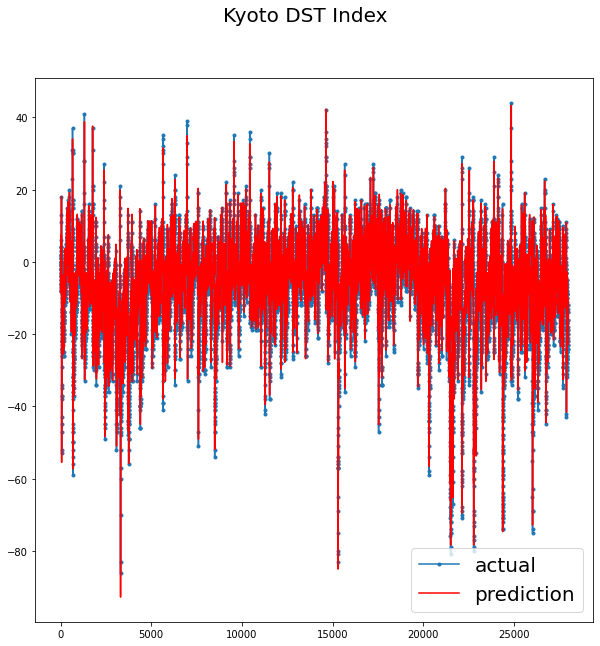

In [13]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y, marker='.', label="actual")
plt.plot(inv_yhat, 'r', label="prediction")
plt.suptitle('Kyoto DST Index', fontsize=20)
plt.legend(fontsize=20)
plt.show()